In [3]:
import pandas as pd 
import numpy as np
import os

%load_ext autoreload
%autoreload 2

import sys
sys.path.append(os.path.dirname(os.getcwd()))

from dotenv import load_dotenv
load_dotenv()

True

## LLM

In [4]:
from climateqa.engine.llm import get_llm
from climateqa.engine.llm.ollama import get_llm as get_llm_ollama

llm = get_llm(provider="openai")
llm.invoke("Say Hello !")


AIMessage(content='Hello! How can I assist you today?', response_metadata={'finish_reason': 'stop'}, id='run-6235ddf2-0b8d-406d-ba68-e80124b67ec8-0')

## Retriever 

In [5]:
from climateqa.engine.vectorstore import get_pinecone_vectorstore
from climateqa.engine.embeddings import get_embeddings_function
from climateqa.knowledge.retriever import ClimateQARetriever

question = "What is the impact of climate change on the environment?"

embeddings_function = get_embeddings_function()
vectorstore_ipcc = get_pinecone_vectorstore(embeddings_function)
docs_question = vectorstore_ipcc.search(query = question, search_type="similarity")
docs_question

Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/tim/ai4s/climate_qa/climate-question-answering/climateqa/engine/vectorstore.py:38: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 0.3.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  vectorstore = PineconeVectorstore(


[Document(metadata={'chunk_type': 'text', 'document_id': 'document6', 'document_number': 6.0, 'element_id': 'N/A', 'figure_code': 'N/A', 'file_size': 'N/A', 'image_path': 'N/A', 'n_pages': 3068.0, 'name': 'Full Report. In: Climate Change 2022: Impacts, Adaptation and Vulnerability. Contribution of the WGII to the AR6 of the IPCC', 'num_characters': 1152.0, 'num_tokens': 223.0, 'num_tokens_approx': 285.0, 'num_words': 214.0, 'page_number': 2516.0, 'release_date': 2022.0, 'report_type': 'Full Report', 'section_header': '(a) Low-lying coastal systems', 'short_name': 'IPCC AR6 WGII FR', 'source': 'IPCC', 'toc_level0': 'Chapters and Cross-Chapter Papers ', 'toc_level1': 'Chapter 16  Key Risks across Sectors and Regions', 'toc_level2': 'N/A', 'toc_level3': 'N/A', 'url': 'https://report.ipcc.ch/ar6/wg2/IPCC_AR6_WGII_FullReport.pdf'}, page_content="'Impact of climate change' is defined as the difference between the observed state of the system and the state of \r\nthe system assuming the same 

In [7]:
# optional filters
sources_owid = ["OWID"]
filters = {}
filters["source"] = {"$in": sources_owid}

# vectorestore_graphs
vectorstore_graphs = get_pinecone_vectorstore(embeddings_function, index_name = os.getenv("PINECONE_API_INDEX_OWID"), text_key="title")
owid_graphs = vectorstore_graphs.search(query = question, search_type="similarity")
owid_graphs = vectorstore_graphs.similarity_search_with_score(query = question, filter=filters, k=5)
owid_graphs

[(Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_349', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/co2-emissions-and-gdp?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Consumption-based emissions are national emissions that have been adjusted for trade. This measures fossil fuel and industry emissions. Land-use change is not included.', 'url': 'https://ourworldindata.org/grapher/co2-emissions-and-gdp'}, page_content='Change in CO2 emissions and GDP'),
  0.668701708),
 (Document(metadata={'category': 'Climate Change', 'doc_id': 'owid_766', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or

## Reranker

In [13]:
from climateqa.engine.reranker import get_reranker
from climateqa.engine.reranker import rerank_docs

reranker = get_reranker("nano")
reranked_docs_question = rerank_docs(reranker,docs_question["docs_full"],question)
reranked_docs_question

Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


[Document(metadata={'chunk_type': 'text', 'document_id': 'document6', 'document_number': 6.0, 'element_id': 'N/A', 'figure_code': 'N/A', 'file_size': 'N/A', 'image_path': 'N/A', 'n_pages': 3068.0, 'name': 'Full Report. In: Climate Change 2022: Impacts, Adaptation and Vulnerability. Contribution of the WGII to the AR6 of the IPCC', 'num_characters': 1152.0, 'num_tokens': 223.0, 'num_tokens_approx': 285.0, 'num_words': 214.0, 'page_number': 2517, 'release_date': 2022.0, 'report_type': 'Full Report', 'section_header': '(a) Low-lying coastal systems', 'short_name': 'IPCC AR6 WGII FR', 'source': 'IPCC', 'toc_level0': 'Chapters and Cross-Chapter Papers ', 'toc_level1': 'Chapter 16  Key Risks across Sectors and Regions', 'toc_level2': 'N/A', 'toc_level3': 'N/A', 'url': 'https://report.ipcc.ch/ar6/wg2/IPCC_AR6_WGII_FullReport.pdf', 'similarity_score': 0.738316119, 'content': "'Impact of climate change' is defined as the difference between the observed state of the system and the state of  the 

# Graph

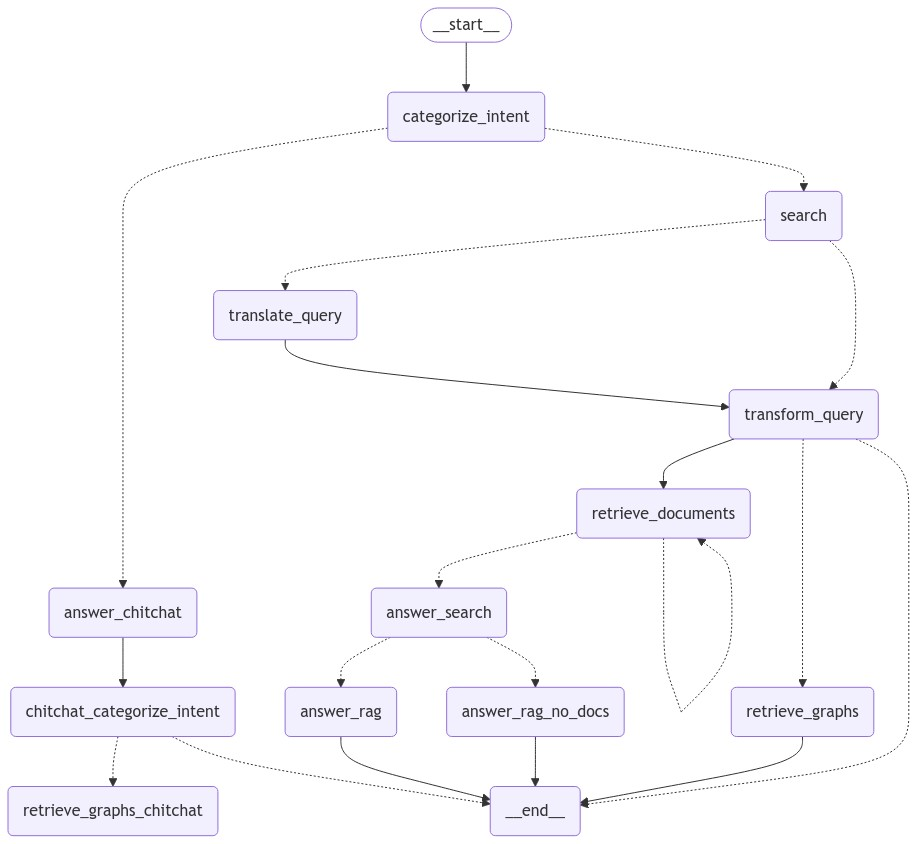

In [18]:
from climateqa.engine.graph import make_graph_agent, display_graph

app = make_graph_agent(llm=llm, vectorstore_ipcc=vectorstore_ipcc, vectorstore_graphs=vectorstore_graphs, reranker=reranker)
display_graph(app)

In [59]:
from climateqa.engine.graph import search 

from climateqa.engine.chains.intent_categorization import make_intent_categorization_node


from climateqa.engine.chains.answer_chitchat import make_chitchat_node
from climateqa.engine.chains.answer_ai_impact import make_ai_impact_node
from climateqa.engine.chains.query_transformation import make_query_transform_node
from climateqa.engine.chains.translation import make_translation_node
from climateqa.engine.chains.retrieve_documents import make_retriever_node
from climateqa.engine.chains.answer_rag import make_rag_node
from climateqa.engine.chains.graph_retriever import make_graph_retriever_node
from climateqa.engine.chains.chitchat_categorization import make_chitchat_intent_categorization_node
from climateqa.engine.chains.prompts import audience_prompts
from climateqa.engine.graph import route_intent


In [60]:
inial_state = {"user_input": "What is the impact of climate change on the environment?", "audience" : audience_prompts["general"],"sources_input":["IPCC"]}
state=inial_state.copy()

In [61]:
cat_node = make_intent_categorization_node(llm)
state.update(cat_node(inial_state))
state

---- Categorize_message ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Output intent categorization: {'intent': 'search'}



{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC'],
 'intent': 'search',
 'language': 'English',
 'query': 'What is the impact of climate change on the environment?'}

In [62]:
state.update(search(state))
state

{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC'],
 'intent': 'search',
 'language': 'English',
 'query': 'What is the impact of climate change on the environment?'}

In [63]:
intent = route_intent(state)

if route_intent(state) == "translate_query":
    make_translation_node(llm)(state)

In [64]:
state.update(make_query_transform_node(llm)(state))
state

---- Transform query ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC'],
 'intent': 'search',
 'language': 'English',
 'query': 'What is the impact of climate change on the environment?',
 'remaining_questions': [{'question': 'What are the effects of climate change on ecosystems?',
   'sources': ['IPCC'],
   'index': 'Vector'},
  {'question': 'How does climate change affect biodiversity and wildlife?',
   'sources': ['IPCC'],
   'index': 'Vector'}],
 'n_questions': 2}

In [65]:
state.update(make_graph_retriever_node(vectorstore_graphs, reranker)(state))
state

---- Retrieving graphs ----
Subquestion 0: What are the effects of climate change on ecosystems?
8 graphs retrieved for subquestion 1: [Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_386', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or region's share of the global mean surface temperature change as a result of its cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/contributions-global-temp-change', 'similarity_score': 0.649586797, 'content': 'Global warming: Contributions to the change in global mean surface temperature', 'reranking_score': 0.004589226096868515, 'query_used_for_retrieval': 'What are the effects of climate change on ecosystem

{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC'],
 'intent': 'search',
 'language': 'English',
 'query': 'What is the impact of climate change on the environment?',
 'remaining_questions': [{'question': 'What are the effects of climate change on ecosystems?',
   'sources': ['IPCC'],
   'index': 'Vector'},
  {'question': 'How does climate change affect biodiversity and wildlife?',
   'sources': ['IPCC'],
   'index': 'Vector'}],
 'n_questions': 2,
 'recommended_content': [Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_386', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-w

In [66]:
retriever_node = make_retriever_node(vectorstore_ipcc, reranker, llm)
retriever_node

RunnableLambda(afunc=retrieve_docs)

In [69]:
new_state = state.copy()
while len(new_state["remaining_questions"])>0:    
    async for temp_state in retriever_node.astream(new_state):
        new_state.update(temp_state)
        print(temp_state)
new_state

---- Retrieve documents ----
{'documents': [Document(metadata={'chunk_type': 'text', 'document_id': 'document9', 'document_number': 9.0, 'element_id': 'N/A', 'figure_code': 'N/A', 'file_size': 'N/A', 'image_path': 'N/A', 'n_pages': 2258.0, 'name': 'Full Report. In: Climate Change 2022: Mitigation of Climate Change. Contribution of the WGIII to the AR6 of the IPCC', 'num_characters': 547.0, 'num_tokens': 104.0, 'num_tokens_approx': 116.0, 'num_words': 87.0, 'page_number': 839, 'release_date': 2022.0, 'report_type': 'Full Report', 'section_header': '7.6.4.3 Ecological Barriers and Opportunities', 'short_name': 'IPCC AR6 WGIII FR', 'source': 'IPCC', 'toc_level0': '7.6 Assessment of Economic, Social and\xa0Policy Responses', 'toc_level1': 'Box\xa07.12 | Financing AFOLU Mitigation; What Are the Costs and Who Pays?', 'toc_level2': 'N/A', 'toc_level3': 'N/A', 'url': 'https://www.ipcc.ch/report/ar6/wg3/downloads/report/IPCC_AR6_WGIII_FullReport.pdf', 'similarity_score': 0.789457798, 'content':

{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC'],
 'intent': 'search',
 'language': 'English',
 'query': 'What is the impact of climate change on the environment?',
 'remaining_questions': [],
 'n_questions': 2,
 'recommended_content': [Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_386', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or region's share of the global mean surface temperature change as a result of its cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxid

In [70]:
answer_rag = await make_rag_node(llm)(new_state,{})
new_state.update(answer_rag)

---- Answer RAG ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Answer:
Climate change has significant and wide-ranging impacts on the environment, affecting ecosystems, biodiversity, and the services they provide. Here are the key points:

### 1. **Alteration of Ecosystems**
- Climate change has already changed terrestrial, freshwater, and ocean ecosystems globally. These changes are evident in the structure of ecosystems, the geographic ranges of species, and the timing of seasonal life cycles (phenology) [Doc 2, Doc 3].
- Key climatic factors driving these changes include rising temperatures, altered precipitation patterns, and extreme weather events, which are unprecedented in the last millennia [Doc 4].

### 2. **Biodiversity Loss**
- Many species are experiencing shifts in their ranges and abundances due to climate change. For instance, bird populations in North America have declined by up to 30% over the past fifty years, with climate change acting as an additional stressor alongside habitat loss and agricultural intensification [Doc 8].
-

# stream event of the whole chain

In [71]:
inial_state

{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC']}

In [72]:
event_list = app.astream_events(inial_state, version = "v1")

In [73]:

async for event in event_list:
    pass

---- Categorize_message ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Output intent categorization: {'intent': 'search'}

---- Transform query ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---- Retrieving graphs ----
Subquestion 0: What are the effects of climate change on ecosystems?
8 graphs retrieved for subquestion 1: [Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_386', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or region's share of the global mean surface temperature change as a result of its cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/contributions-global-temp-change', 'similarity_score': 0.649586797, 'content': 'Global warming: Contributions to the change in global mean surface temperature', 'reranking_score': 0.004589226096868515, 'query_used_for_retrieval': 'What are the effects of climate change on ecosystem

---- Retrieve documents ----


---- Answer RAG ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Answer:
Climate change has significant and wide-ranging impacts on the environment, affecting ecosystems, biodiversity, and the services they provide. Here are the key points:

### 1. **Alteration of Ecosystems**
- Climate change has already changed terrestrial, freshwater, and ocean ecosystems globally. These changes are evident in the structure of ecosystems, the geographic ranges of species, and the timing of seasonal life cycles (phenology) [Doc 2, Doc 3].
- Key climatic factors driving these changes include rising temperatures, altered precipitation patterns, and extreme weather events, which are unprecedented in the last millennia [Doc 4].

### 2. **Biodiversity Loss**
- Many species are experiencing shifts in their ranges and abundances due to climate change. For instance, bird populations in North America have declined by up to 30% over the past fifty years, with climate change acting as an additional stressor alongside habitat loss and agricultural intensification [Doc 8].
-